In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")


data = {
    "Year": [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    "Hazardous Waste Managed": [1684318.5, 263971.3, 261188.0, 453373.1, 227555.0, 303116.6, 420668.3, 355952.5, 382214.3, 337414.8, 251565.7, 151391.1, 126874.6, 149962.4, 180506.7, 137828.0, 42090.0, 46487.8, 43867.9],
    "Reused/Recycled": [10918.2, 263971.3, 238846.6, 282182.8, 59468.1, 20235.1, 45604.9, 95628.1, 82337.5, 110555.3, 74553.4, 33657.8, 190785.6, 29992.8, 36645.9, 30711.8, 4924.0, 3388.7, 2796.7],
        }

df = pd.DataFrame(data)
df

,Year,Hazardous Waste Managed,Reused/Recycled
0,2005,1684318.5,10918.2
1,2006,263971.3,263971.3
2,2007,261188.0,238846.6
3,2008,453373.1,282182.8
4,2009,227555.0,59468.1
5,2010,303116.6,20235.1
6,2011,420668.3,45604.9
7,2012,355952.5,95628.1
8,2013,382214.3,82337.5
9,2014,337414.8,110555.3


In [4]:
df.dtypes

Year                         int64
Hazardous Waste Managed    float64
Reused/Recycled            float64
dtype: object

In [5]:
df.set_index("Year", inplace=True)

In [6]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
df_scaled

,Hazardous Waste Managed,Reused/Recycled
Year,,
2005,3.971898,-0.836978
2006,-0.122106,2.017550
2007,-0.130129,1.734135
2008,0.423825,2.222982
2009,-0.227072,-0.289318
2010,-0.009274,-0.731880
2011,0.329557,-0.445699
2012,0.143020,0.118580
2013,0.218717,-0.031343


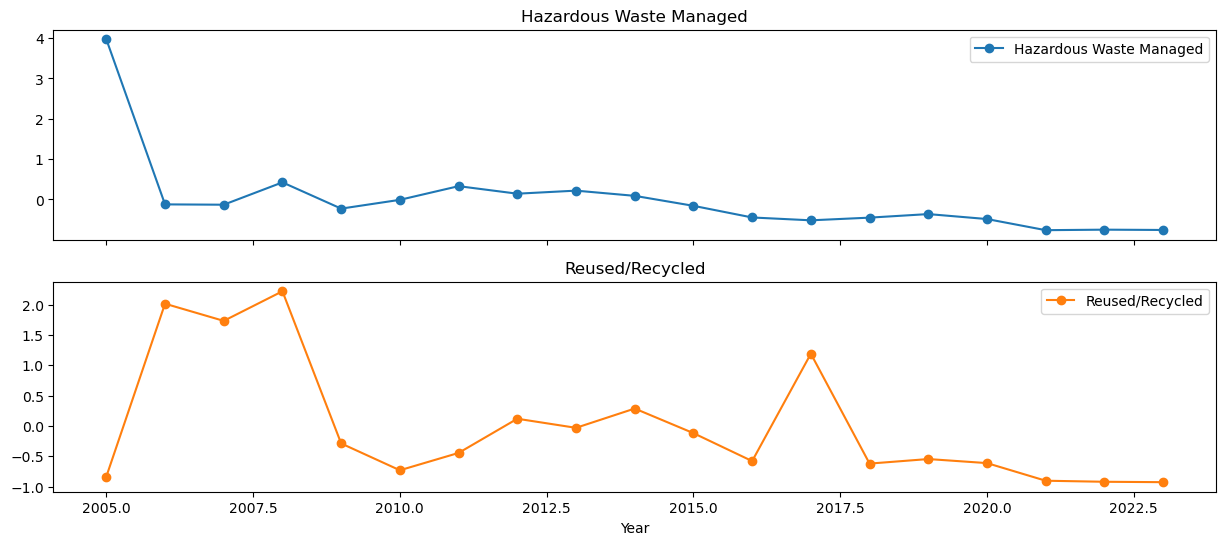

In [7]:
df_scaled.plot(subplots=True, figsize=(15, 6),marker ="o", title=["Hazardous Waste Managed", "Reused/Recycled"])
plt.show()

In [8]:
train_data = df_scaled["Hazardous Waste Managed"][:-1]  
test_data = df_scaled["Hazardous Waste Managed"][-1:]  

model = ARIMA(train_data, order=(1, 1, 1))  # order = (p, d, q)
arima_model = model.fit()

print(arima_model.summary())

                                  SARIMAX Results                                  
Dep. Variable:     Hazardous Waste Managed   No. Observations:                   18
Model:                      ARIMA(1, 1, 1)   Log Likelihood                 -22.875
Date:                     Sat, 28 Dec 2024   AIC                             51.749
Time:                             11:33:12   BIC                             54.249
Sample:                                  0   HQIC                            51.998
                                      - 18                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2908      0.184      1.581      0.114      -0.070       0.651
ma.L1          0.9963     37.928      0.026      0.979     -73.341      75.333
sigma2      

In [9]:
forecast = arima_model.forecast(steps=1)
print(f"Forecasted hazardous waste managed for the next year: {forecast.values[0]}")

predictions = arima_model.predict(start=len(train_data), end=len(df_scaled) - 1, typ="levels")
mse = mean_squared_error(test_data, predictions)
print(f"MSE: {mse}")

Forecasted hazardous waste managed for the next year: -0.7886039720099527
MSE: 0.0010286390599159945


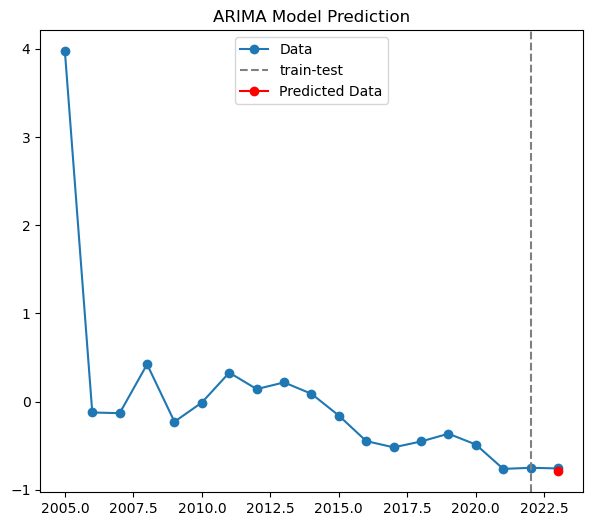

In [10]:
plt.figure(figsize=(7, 6))
plt.plot(df_scaled.index, df_scaled["Hazardous Waste Managed"], label="Data", marker="o")
plt.axvline(x=df_scaled.index[-2], color="gray", linestyle="--", label="train-test")
plt.plot(test_data.index, predictions, label="Predicted Data", color="red", marker="o")
plt.legend()
plt.title("ARIMA Model Prediction")
plt.show()

Mean Squared Error (MSE) - Random Forest: 0.10633982398847996


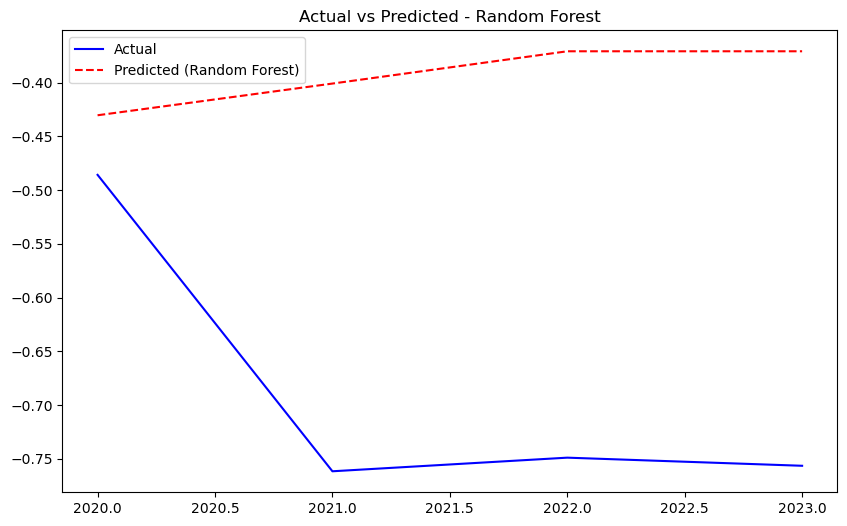

In [11]:
def create_lag_features(df, lag=1):
    df_lagged = df.copy()
    for i in range(1, lag + 1):
        df_lagged[f"lag_{i}"] = df_lagged["Hazardous Waste Managed"].shift(i)
    df_lagged = df_lagged.dropna() 
    return df_lagged

df_lagged = create_lag_features(df_scaled, lag=2)

X = df_lagged[["lag_1", "lag_2"]]  
y = df_lagged["Hazardous Waste Managed"]  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Mean Squared Error (MSE) - Random Forest: {mse_rf}")

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="Actual", color='blue')
plt.plot(y_test.index, y_pred_rf, label="Predicted (Random Forest)", color='red', linestyle='--')
plt.title("Actual vs Predicted - Random Forest")
plt.legend()
plt.show()

In [12]:
y = df['Hazardous Waste Managed'] 

p_values = range(0, 3)  
d_values = range(0, 2)  
q_values = range(0, 3)  
best_aic = np.inf
best_order = None
best_model = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(y, order=(p, d, q))
                model_fitted = model.fit()

                if model_fitted.aic < best_aic:
                    best_aic = model_fitted.aic
                    best_order = (p, d, q)
                    best_model = model_fitted
            except:
                continue  
print(f"Best ARIMA order: {best_order}")
print(f"Best AIC: {best_aic}")

Best ARIMA order: (0, 1, 0)
Best AIC: 512.3207135585965


In [13]:
data1 = {
    "Year": [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    "Hazardous Waste Managed": [1684318.5, 263971.3, 261188.0, 453373.1, 227555.0, 303116.6, 420668.3, 355952.5, 382214.3, 337414.8, 251565.7, 151391.1, 126874.6, 149962.4, 180506.7, 137828.0, 42090.0, 46487.8, 43867.9],
    "Reused/Recycled": [10918.2, 263971.3, 238846.6, 282182.8, 59468.1, 20235.1, 45604.9, 95628.1, 82337.5, 110555.3, 74553.4, 33657.8, 190785.6, 29992.8, 36645.9, 30711.8, 4924.0, 3388.7, 2796.7],
        }

df1 = pd.DataFrame(data1)
df1

,Year,Hazardous Waste Managed,Reused/Recycled
0,2005,1684318.5,10918.2
1,2006,263971.3,263971.3
2,2007,261188.0,238846.6
3,2008,453373.1,282182.8
4,2009,227555.0,59468.1
5,2010,303116.6,20235.1
6,2011,420668.3,45604.9
7,2012,355952.5,95628.1
8,2013,382214.3,82337.5
9,2014,337414.8,110555.3


In [14]:
df1.set_index("Year", inplace=True)

In [15]:
scaler1 = StandardScaler()
df_scaled1 = scaler.fit_transform(df1)
df_scaled1 = pd.DataFrame(df_scaled1, columns=df1.columns, index=df1.index)
df_scaled1

,Hazardous Waste Managed,Reused/Recycled
Year,,
2005,3.971898,-0.836978
2006,-0.122106,2.017550
2007,-0.130129,1.734135
2008,0.423825,2.222982
2009,-0.227072,-0.289318
2010,-0.009274,-0.731880
2011,0.329557,-0.445699
2012,0.143020,0.118580
2013,0.218717,-0.031343


In [16]:
train_data1 = df_scaled1["Hazardous Waste Managed"] 
test_data1 = df_scaled1["Hazardous Waste Managed"]  

model1 = ARIMA(train_data1, order=(1, 1, 1))  # order = (p, d, q)
arima_model1 = model1.fit()

print(arima_model1.summary())

                                  SARIMAX Results                                  
Dep. Variable:     Hazardous Waste Managed   No. Observations:                   19
Model:                      ARIMA(1, 1, 1)   Log Likelihood                 -23.632
Date:                     Sat, 28 Dec 2024   AIC                             53.264
Time:                             11:34:34   BIC                             55.935
Sample:                                  0   HQIC                            53.632
                                      - 19                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3079      0.166      1.859      0.063      -0.017       0.633
ma.L1          0.9965     33.365      0.030      0.976     -64.398      66.391
sigma2      

In [19]:
forecast1 = arima_model1.forecast(steps=1)
print(f"Forecasted hazardous waste managed for 2024: {forecast1.values[0]}")

Forecasted hazardous waste managed for 2024: -0.0735502312775545


In [20]:
train_size = int(len(df_scaled1) * 0.8)
train_data1 = df_scaled1["Hazardous Waste Managed"][:train_size]
test_data1 = df_scaled1["Hazardous Waste Managed"][train_size:]

model1 = ARIMA(train_data1, order=(1, 1, 1))  # ARIMA(p, d, q)
arima_model1 = model1.fit()

start = train_size
end = len(df_scaled1) - 1
predictions1 = arima_model1.predict(start=start, end=end, typ="levels")

mse1 = mean_squared_error(test_data1, predictions1)
print(f"MSE: {mse1}")


MSE: 0.486970385814658


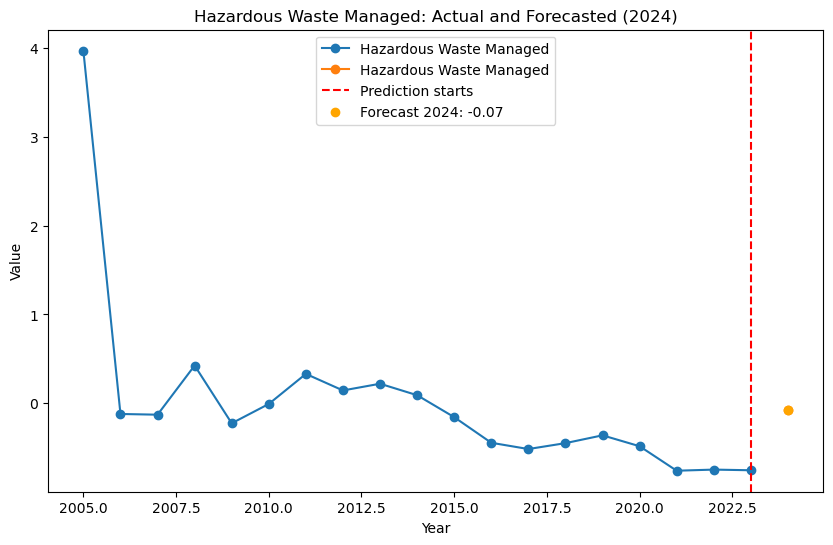

In [37]:
forecast1 = arima_model1.forecast(steps=1)
forecasted_value = forecast1.values[0]

forecast_year = 2024
scaled_forecast = [forecasted_value]
df_forecast = pd.DataFrame(
    scaled_forecast, index=[forecast_year], columns=["Hazardous Waste Managed"]
)

combined_df = pd.concat([df_scaled1["Hazardous Waste Managed"], df_forecast])

plt.figure(figsize=(10, 6))
plt.plot(combined_df.index, combined_df, label="Hazardous Waste Managed", marker='o')
plt.axvline(x=2023, color='red', linestyle='--', label="Prediction starts")
plt.scatter(forecast_year, forecasted_value, color='orange', label=f"Forecast 2024: {forecasted_value:.2f}", zorder=5)
plt.title("Hazardous Waste Managed: Actual and Forecasted (2024)")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.show()